# Risk-aware planning with RAPTOR in JaxPlan.

This variation of the closed-loop planning notebook optimizes a nonlinear risk-aware utility function.

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet seaborn
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
import seaborn as sns

import pyRDDLGym
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, load_config_from_string

Let's optimize the power generation domain from the IPPC 2023:

In [3]:
env = pyRDDLGym.make('PowerGen_Continuous', '0', vectorized=True)

Let's generate a risk-neutral baseline from the policy network:

In [4]:
config = """
[Model]
[Optimizer]
method='JaxDeepReactivePolicy'
method_kwargs={'topology': [64, 64]}
optimizer_kwargs={'learning_rate': 0.0002}
batch_size_train=128
[Training]
"""
planner_args, _, train_args = load_config_from_string(config)
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False, train_seconds=45, **train_args)
drp_returns = [agent.evaluate(env, episodes=1)['mean'] for _ in range(100)]

[INFO] Bounds of action-fluent <curProd> set to (array([0., 0., 0.], dtype=float32), array([10., 10., 10.], dtype=float32)).
[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /   -39924.20312 train /   -39801.13281 test /   -39801.13281 best / 0 status /      1 pgpe:  10%|▉         | 00:03 , 0.22it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    814 it /   -20728.40234 train /     -838.73975 test /     -811.07166 best / 5 status /    100 pgpe: 100%|██████████| 00:44 , 18.10it/s


Next, let's repeat the example, but this time we will use the conditional value at risk to optimize the lower 10 percent of the returns. This should produce a policy that is more robust against power shortages:

In [5]:
config = """
[Model]
[Optimizer]
method='JaxDeepReactivePolicy'
method_kwargs={'topology': [64, 64]}
optimizer_kwargs={'learning_rate': 0.0002}
utility='cvar'
utility_kwargs={'alpha': 0.1}
batch_size_train=128
[Training]
"""
planner_args, _, train_args = load_config_from_string(config)
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False, train_seconds=45, **train_args)
risk_returns = [agent.evaluate(env, episodes=1)['mean'] for _ in range(100)]

[INFO] Bounds of action-fluent <curProd> set to (array([0., 0., 0.], dtype=float32), array([10., 10., 10.], dtype=float32)).
[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /   -39405.94141 train /   -28903.37500 test /   -28903.37500 best / 0 status /      1 pgpe:  10%|▉         | 00:03 , 0.23it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    842 it /   -21268.28906 train /    -1305.57080 test /    -1284.35364 best / 5 status /    104 pgpe: 100%|██████████| 00:44 , 18.73it/s


Finally, let's plot two overlapping histograms comparing the distribution of returns for the two plans:

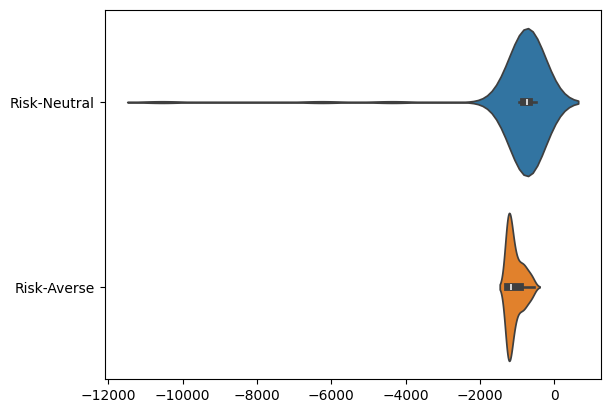

In [6]:
%matplotlib inline
ax = sns.violinplot(data=[drp_returns, risk_returns], orient='h')
ax.set_yticklabels(['Risk-Neutral', 'Risk-Averse'])
plt.show()

As you can see, the returns are more stable with the utility objective.